In [1]:
import math
import pickle
import time
import random
import numpy as np

import kmeans
import Cplex_CalculateFitness

import matplotlib.pyplot as plt
from matplotlib import figure

In [2]:
# variables
file = open("fitness_values.pickle", "rb")
fitness_values = pickle.load(file)
file.close()

solution_individuals = []
solution_costs = []

# ideas

- update mutation probability adaptively

# definitions

Gene: a city (represented as (x, y) coordinates)       
Individual (aka “chromosome”): a single route satisfying the conditions above        
Population: a collection of possible routes (i.e., collection of individuals)    
Parents: two routes that are combined to create a new route         
Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)   
Fitness: a function that tells us how good each route is (in our case, how short the distance is)       
Mutation: a way to introduce variation in our population by randomly swapping two cities in a route          
Elitism: a way to carry the best individuals into the next generation      

# decisions in ga

+ Chromosome representation or coding of an individual solution   
+ Fitness function   
- Population size, generation of initial population  
+ Parent selection for reproduction  
+ Crossover operator, crossover rate/probability (pc)  
+ Mutation operator, mutation probability (pm),  
+ Forming the population for next generation  
+ Stopping (convergence) condition  

key of a population dictionary: list(ind.ravel())

### k-means

size=(500, 100)
points = np.random.random(size=size)*10
clusters, centroids = kmeans.kmeans(points, k)

### generate initial population

x adet  initial population için 5x random çözüm bul ve bunların fitnesslarını ve birbiriyle olan benzemezliklerini hesapla. bu iki değere göre en iyi x taneyi initial olarak al.
sadece benzemezlik değerine göre al.

initial population alırken 5x feasible initial solution'u alıp dbscan ya da kmeans ile diversiy sonuçlar elde edebiliriz.

In [3]:
def initialize_population(pop_size):
    '''
    Initializing a population which has feasible and random individuals.
    
    Args:
        ind_size (tuple): size of each individual
        pop_size (int) : number of individuals will be created
        lower_limit (int) : the lower limit of each value can take
        upper_limit (int) : the upper limit of each value can take
    Returns:
        initial_population (array) : list of individuals formed by random integers
    '''

    initial_population = Cplex_CalculateFitness.generate_random_array(pop_size)
    
    # initial_population = np.random.randint(lower_limit, upper_limit, size=(pop_size, ind_size))
    
    return initial_population

### calculate fitness 

In [4]:
def calculate_fitness(individual):
    
    def fitness(key):
        
        try:
            fitness_values[key] = Cplex_CalculateFitness.calculate_fitness(individual)
        except:
            return 999999.9 # if a solution is not feasible then assign its obj func
        return fitness_values[key]
    
    # key = str(list(individual.ravel()))
    key = str(individual)
    
    return fitness_values.get(key, fitness(key))

### selection rule

In [5]:
def create_mating_pool(population, fitness_func, elitism_ratio, max_parent_allow, pop_size, choice_size=2):

    t0 = time.time()
    if fitness_func == 'cost':
        
        # calculating choice probabilities of a population
        def calculate_probabilities(population):

            fitness_values = [1/calculate_fitness(individual) for individual in population]
            total_fitness = sum(fitness_values)
            choice_probabilities = [fv/total_fitness for fv in fitness_values]   
            
            return choice_probabilities
        
    elif fitness_func == 'distance':
        
        # calculating choice probabilities of a population based on total distance of an ind to others
        def calculate_probabilities(population):

            # calculating euclidean distance between two individual
            def calculate_distance(x, y):
                return np.sqrt(sum((x-y)**2))

            # import kmeans
            # fitness_values = [sum([kmeans.calculate_distance(ind1, ind2) for ind2 in population]) for ind1 in population]        
            fitness_values = [sum([calculate_distance(ind1, ind2) for ind2 in population]) for ind1 in population]

            total_fitness = sum(fitness_values)
            choice_probabilities = [fv/total_fitness for fv in fitness_values]   

            return choice_probabilities
    
    t1 = time.time() 
    print('step 1', t1-t0) 
    
    mating_pool = [] 
    # each individual can be a parent for limited times
    times_parent = np.zeros(pop_size)  
    
    # if elitism raio is greater than 0, add elite solutions to mating pool
    if elitism_ratio > 0:
        
        # determining elite solutions
        elite_individual_number = int(elitism_ratio*pop_size)
        
        costs = [calculate_fitness(individual) for individual in population]

        best_individual_indexes = sorted(range(len(costs)), key=lambda i: costs[i])[:elite_individual_number]
        
        # adding elite solutions to the mating pool
        for i in range(0,len(best_individual_indexes),choice_size):
            parent_indexes = [best_individual_indexes[i], best_individual_indexes[i+1]]
            mating_pool.append(parent_indexes)
            times_parent[parent_indexes] += 1

    t2 = time.time() 
    print('step 2', t2-t1) 

    # in each step 'choice_size' of parents will be chosen for number of steps
    while len(mating_pool) < pop_size//choice_size:
        
        # drawing 'choice_size' random uniform numbers
        draws = np.random.uniform(0, 1, choice_size)
        
        # index array to control parent eligibility in a population
        idx_array = np.array(range(pop_size))
        
        # an individual can be a parent if it didn't chosen as parent 'max_parent_allow*pop_size' times
        idx_array = idx_array[times_parent<int(max_parent_allow*pop_size)]
        
        parent_indexes = []
        
        # choosing an individual according to the draw probability
        for draw in draws:
           
            accumulated = 0
      
            for idx, probability in zip(idx_array, calculate_probabilities(population[idx_array])):
                
                accumulated += probability

                if draw <= accumulated:

                    parent_indexes.append(idx)
                    idx_array = idx_array[idx_array!=parent_indexes]

                    break
        
        # if the mate is not exist in the mating pool add it
        if parent_indexes not in mating_pool and parent_indexes[::-1] not in mating_pool:           

            mating_pool.append(parent_indexes)
            times_parent[parent_indexes] += 1
    
    t3 = time.time() 
    print('step 3', t3-t2) 
    
    return np.array([population[mate] for mate in mating_pool])

### crossover operator

In [6]:
def crossover_operator(parents, crossover_point, crossover_prob, ind_size):
    '''
    Crossover operator for given parents to create new offsprings. 
    Args:
        parent_1, parent_1: parents for crossover
        crossover_point: represents crossover type; 1-point, 2-point etc.
        crossover_prob: probability of crossover, default value is 1.0
    Returns:
        [parent_1, parent_2]: if no crossover happens returns the parents
        [offspring_1, offspring_2]: if crossover happens returns offsprings
    '''
    
    # make crossover with probability of crossover_probability else return parents
    draw = np.random.uniform(0, 1)
    
    if draw > crossover_prob:
        return parents

    parent_1, parent_2 = parents
        
    # choosing random two points between 1 and size of individual to determine cutpoints
    random_points = list(np.random.choice(np.arange(1,ind_size-1), crossover_point, replace=False)) 
    
    # creating start and end points of cuts
    cutpoints = sorted(random_points + [0, ind_size])
    cut_pieces = {cutpoints[i]:cutpoints[i+1] for i in range(len(cutpoints)-1)}
    
    # cutting parents from the given cut points
    parent_pcs = [(parent_1[start:end], parent_2[start:end]) for start, end in cut_pieces.items()]
    
    # crossover parents from cutpoints, n-point crossover is used (exchanging pieces from different parents)
    mask = 0
    
    offspring_1 = np.array([], dtype=int)
    offspring_2 = np.array([], dtype=int)
    
    for pcs1, pcs2 in parent_pcs:
        
        if mask%2 == 0:
            # print('1. if: off1,2 pcs1,2', offspring_1.shape, offspring_2.shape, pcs1.shape, pcs2.shape)
            offspring_1 = np.append(offspring_1, pcs1)
            offspring_2 = np.append(offspring_2, pcs2) 
        else:
            # print('2. if: off1,2 pcs1,2', offspring_1.shape, offspring_2.shape, pcs1.shape, pcs2.shape)
            offspring_1 = np.append(offspring_1, pcs2)
            offspring_2 = np.append(offspring_2, pcs1)
        
        mask +=1
        
    return np.array([offspring_1, offspring_2])

### mutation operator

In [7]:
def mutation_operator(offsprings, m_probability, m_rate, m_level, ind_size):
    
    mutated_offsprings = []
    
    # the number of genes will be mutated
    mutation_size = int(m_rate*ind_size)
    
    for offspring in offsprings:
        
        # mutate individuals with 'mutation_probability'
        if np.random.uniform(0, 1) < m_probability:
            
            # choose some random number to decide which genes will be mutated
            mutation_mask = np.random.choice(range(ind_size), size=mutation_size, replace=False)
            
            # determine whether or not a gene will increase or decrease by 'mutation_level' 
            mutation_multiplier = m_level*np.random.choice([-1,1], size=mutation_size, replace=True) + 1
            
            # updating genes using'mutation_mask' by 'mutation_multiplier'
            offspring[mutation_mask] = offspring[mutation_mask]*mutation_multiplier
            
            mutated_offsprings.append(offspring)
        
        else:
            mutated_offsprings.append(offspring)
            
    return np.array(mutated_offsprings)

### printing results

In [8]:
def stop_algorithm(iter_count, max_iter):
    
    print('---------------------------------------------------')
    print('Algorithm finished...')
    print()
    if iter_count == max_iter-1:
        print(iter_count, max_iter)
        print('Stopping condition: Max iterations reached!')
    else:
        print('Stopping condition: Convergence!')
        
    print('---------------------------------------------------')
    
    global_min_cost = min(solution_costs)
    min_index = solution_costs.index(global_min_cost)
        
    global_best_solution = solution_individuals[min_index]
    
    # dumping the results to a pickle object
    filehandler = open("fitness_values.pickle","wb")
    pickle.dump(fitness_values,filehandler)
    filehandler.close()

    print('Best cost function: ', global_min_cost)
    print('--------')
    print('Best individual: ')
    print(global_best_solution)
    print()
    
    x = range(len(solution_costs))
    y = solution_costs

    plt.plot(x, y)
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.title('Cost Function')

### generate population

In [9]:
def run(parameters):
    
    ind_size, pop_size,\
    n_iter, \
    fitness_func,  cros_type, cros_probability, \
    elit_ratio, max_parent_all, \
    mut_prob, mut_rate, mut_level, \
    max_iter, stop_thrs = parameters
    
    
    # initialize generation
    
    t0 = time.time()
    
    generation = initialize_population(pop_size) # array
    iter_count = 0
    
    start_time = time.time()
    
    
    while iter_count < max_iter:
        
        # generating new population with previous population
        
        prev_generation = generation
        
        generation_list = []
        # creating mating pool
        
        t2 = time.time()
        
        mating_pool = create_mating_pool(prev_generation, fitness_func, elit_ratio, max_parent_all, pop_size)
        
        t3 = time.time()
        print('create_mating_pool: ',t3-t2)
        
        # creating new offsprings by crossover and mutation
        for mate in mating_pool: 

            offsprings = crossover_operator(mate, cros_type, cros_probability, ind_size)
            mutated_offsprings = mutation_operator(offsprings, mut_prob, mut_rate, mut_level, ind_size)
            [generation_list.append(i) for i in mutated_offsprings]
        
        generation = np.array(generation_list)
        
        
        # calculating costs of new generation
        cost_values = [calculate_fitness(individual) for individual in generation]
        
        # saving min cost and related individual obtained in this iteration
        min_itr_cost = min(cost_values)
        min_itr_index = cost_values.index(min_itr_cost)
        min_itr_individual = generation[min_itr_index]
        
        # if the last 5 solutions are the same then stop the algorithm
        if len(solution_costs) > stop_thrs and sum([i==min_itr_cost for i in solution_costs[-stop_thrs:]])>stop_thrs-1:
    
            break
            
        solution_individuals.append(min_itr_individual)
        solution_costs.append(min_itr_cost)
        
        iter_count +=1
        if iter_count % (max_iter//10) == 0:
            print('iteration: ',iter_count)
            print('min cost found: ', min(solution_costs))
    
    t5 = time.time()
    print('iteration time: ',t5-start_time)
    
    stop_algorithm(iter_count, max_iter)
    
    finish_time = time.time()
    print('Algorithm runnig time: ', finish_time-start_time)

# parameters

In [10]:
individual_size = 120

### algorithm settings

In [11]:
k = 10 # number of clusters in k-means
population_size = 30 

# crossover parameters
crossover_probability = 0.7
crossover_type = 1 # integer for n-point crossover
fitness_function = 'cost' # fitness function type; cost or distance based ['cost', 'distance']

# must be even!
elitism_ratio = 0.2  # percentage of best population will carry over to the next generation
max_parent_allowance = 3 # population_size//8 # maximum number of times an individual can be a parent during selection process

#mutation parameters
mutation_probability = 0.05 # probability of mutation
mutation_rate = 0.1 # rate of mutation for an individual
mutation_level = 0.3 # percentage of increase/decrease for a gene during mutation

# algorithm settings
max_iter = 100
stop_thrs = 10

### run with above parameters

In [12]:
parameters = [
                individual_size, population_size, \
                max_iter, \
                fitness_function,  crossover_type, crossover_probability, \
                elitism_ratio, max_parent_allowance, \
                mutation_probability, mutation_rate, mutation_level, \
                max_iter, stop_thrs
             ]

step 1 0.0
step 2 1.6854066848754883


C:\Users\IsmailKaraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


step 3 39.687185525894165
create_mating_pool:  41.373592138290405
step 1 0.0
step 2 1.7003824710845947
step 3 39.724878787994385
create_mating_pool:  41.42626166343689
step 1 0.0
step 2 1.6683757305145264
step 3 42.91068243980408
create_mating_pool:  44.580058574676514
step 1 0.0
step 2 1.6723766326904297
step 3 39.34486126899719
create_mating_pool:  41.01723790168762
step 1 0.0
step 2 1.6733767986297607
step 3 39.3218560218811
create_mating_pool:  40.995232820510864
step 1 0.0
step 2 1.665374994277954
step 3 39.310853481292725
create_mating_pool:  40.97622847557068
step 1 0.0
step 2 1.6793780326843262
step 3 39.41788411140442
create_mating_pool:  41.097262144088745
step 1 0.0
step 2 1.676377534866333
step 3 39.3168580532074
create_mating_pool:  40.99323558807373
step 1 0.0
step 2 1.6723768711090088
step 3 39.49189305305481
create_mating_pool:  41.165271043777466
step 1 0.0
step 2 1.710385799407959
step 3 39.595601320266724
create_mating_pool:  41.30598711967468
iteration:  10
min cost

step 1 0.0
step 2 1.6474010944366455
step 3 38.97646903991699
create_mating_pool:  40.62487077713013
step 1 0.0
step 2 1.655372142791748
step 3 38.94647526741028
create_mating_pool:  40.602855920791626
iteration:  80
min cost found:  17.318001123126425
step 1 0.0
step 2 1.6443700790405273
step 3 38.854119300842285
create_mating_pool:  40.49848937988281
step 1 0.0
step 2 1.6463708877563477
step 3 38.91510534286499
create_mating_pool:  40.56147623062134
step 1 0.0
step 2 1.647399663925171
step 3 42.22175216674805
create_mating_pool:  43.86915183067322
step 1 0.0
step 2 1.6423697471618652
step 3 42.18826246261597
create_mating_pool:  43.83063220977783
step 1 0.0
step 2 1.6483714580535889
step 3 38.946789503097534
create_mating_pool:  40.59616994857788
step 1 0.0
step 2 1.6533725261688232
step 3 39.00337243080139
create_mating_pool:  40.656744956970215
step 1 0.0
step 2 1.650362253189087
step 3 42.16352987289429
create_mating_pool:  43.81490182876587
step 1 0.0
step 2 1.6533799171447754
st

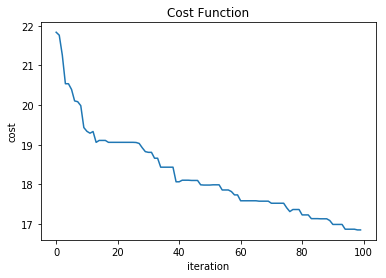

In [13]:
run(parameters)

In [15]:
4291/60

71.51666666666667

### tuning parameters

In [ ]:
k = [5, 10, 20] 
population_size = [20,30,50,100]

# crossover parameters
crossover_probability = [0.5, 0.7, 1.0]
crossover_type = [1, 2, 3] 
fitness_function = ['cost', 'distance']

# must be even!
elitism_ratio = [0, 0.2, 0.4] 
max_parent_allowance = [0.125, 0.25, 0.5]

#mutation parameters
mutation_probability = [0, 0.05, 0.1] # probability of mutation
mutation_rate = [0.05, 0.5] # rate of mutation for an individual
mutation_level = [0.1, 0.3, 0.5] # percentage of increase/decrease for a gene during mutation

# algorithm settings
max_iter = [100, 500, 1000] 
stop_thrs = 10

In [ ]:
solution_costs